In [3]:
import sys
sys.path.insert(0, '../')

""" This module implements the base function to implement a VQE for a Ising Chain with Transverse Field. """
import pennylane as qml
from pennylane import numpy as np
import numpy as onp
import jax
import jax.numpy as jnp
from jax import jit
from functools import partial

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars


import vqe as vqe
import annni_model as annni
import hamiltonians as ham
import ising_chain as ising_chain
import jax.profiler

# System parameters
N = 4
J = 1

# Learning parameters
lr = .05
epochs = 500000
reg = 1

In [2]:
Hs = ham.hamiltonian(annni.build_Hs, N = 8, n_states = 10)

myvqe = vqe.vqe(Hs, vqe.circuit_annni)

myvqe.train(lr, 10, circuit = True, recycle = True, reg = 0)
myvqe.train(lr, epochs, circuit = False, recycle = False, reg = reg)

+--- CIRCUIT ---+
0: ──RY(0.00)──||─╭IsingXX(8.00)───────────────────────────────────────────────────────────────
1: ──RY(1.00)──||─╰IsingXX(8.00)─╭IsingXX(9.00)────────────────────────────────────────────────
2: ──RY(2.00)──||────────────────╰IsingXX(9.00)─╭IsingXX(10.00)────────────────────────────────
3: ──RY(3.00)──||───────────────────────────────╰IsingXX(10.00)─╭IsingXX(11.00)────────────────
4: ──RY(4.00)──||───────────────────────────────────────────────╰IsingXX(11.00)─╭IsingXX(12.00)
5: ──RY(5.00)──||───────────────────────────────────────────────────────────────╰IsingXX(12.00)
6: ──RY(6.00)──||──────────────────────────────────────────────────────────────────────────────
7: ──RY(7.00)──||──────────────────────────────────────────────────────────────────────────────

───────────────────────────────────||──RZ(15.00)──RX(23.00)──||─╭IsingXX(31.00)────────────────
───────────────────────────────────||──RZ(16.00)──RX(24.00)──||─│───────────────╭IsingXX(32.00)
─────────────────────

91/100: 100%|███████████████████████████████████| 99/99 [00:34<00:00,  2.90it/s]
Cost: 0.0000 | Mean F.: 0.8001: 100%|█| 500000/500000 [1:33:35<00:00, 89.05it/s]


Text(0, 0.5, 'L')

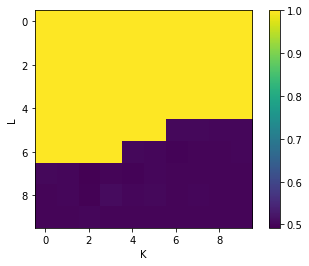

In [3]:
plt.imshow( np.rot90( np.reshape(myvqe.get_fidelties(myvqe.vqe_states),(10,10)) ) )
plt.colorbar()
plt.xlabel('K')
plt.ylabel('L')

In [6]:
myvqe.save('bigrun.plk')

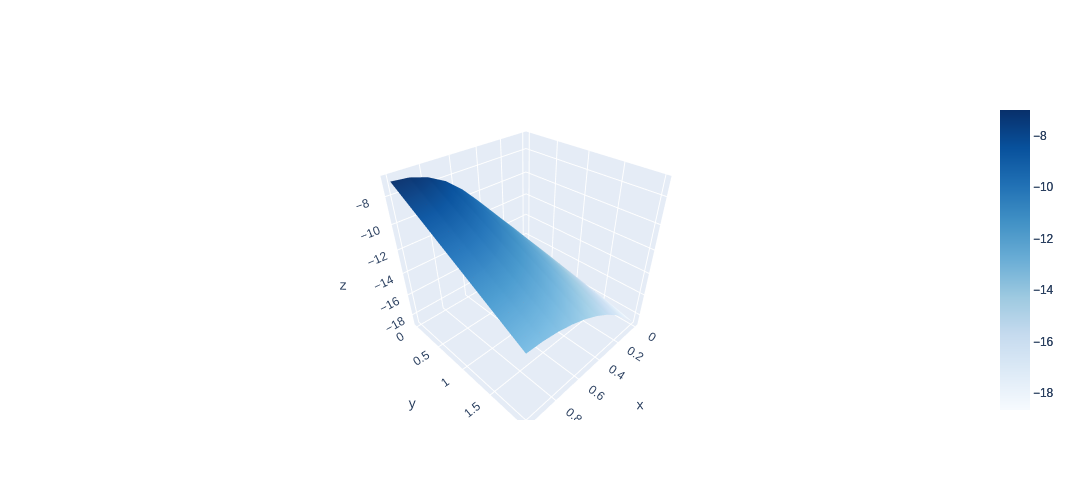

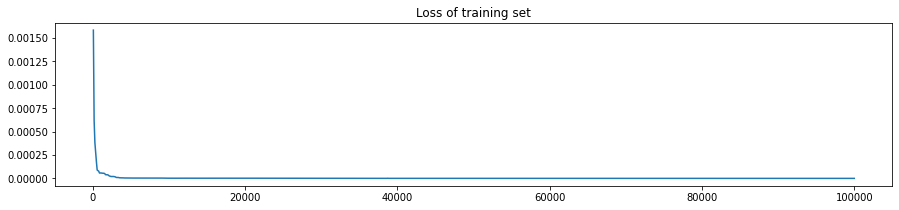

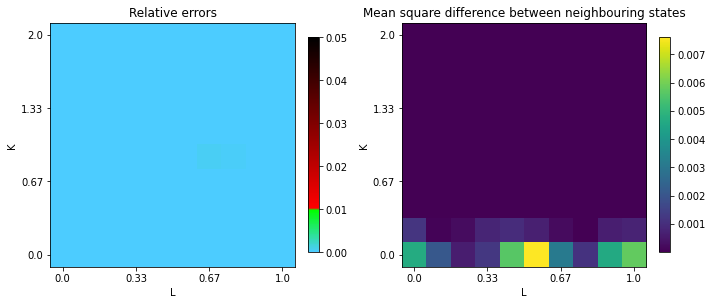

In [7]:
myvqe.show_results_annni()

In [4]:
""" This module implements the base functions to implement a VQE for a Ising Chain with Transverse Field. """
import pennylane as qml
from pennylane import numpy as np
import jax
import jax.numpy as jnp
from jax import jit
from jax.example_libraries import optimizers

from matplotlib import pyplot as plt

import copy
import tqdm  # Pretty progress bars
import joblib  # Writing and loading

import warnings

warnings.filterwarnings(
    "ignore",
    message="For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires.Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.",
)

import sys, os
sys.path.insert(0, '../../')
import PhaseEstimation.circuits as circuits

##############

def qcnn_circuit(params_vqe, vqe_circuit_fun, params, N, n_outputs):
    """
    Building function for the circuit:
          VQE(params_vqe) + QCNN(params)

    Parameters
    ----------
    params_vqe : np.ndarray
        Array of VQE parameters (states)
    vqe_circuit_fun : function
        Function of the VQE circuit
    params : np.ndarray
        Array of QCNN parameters
    N : int
        Number of qubits

    Returns
    -------
    int
        Total number of parameters needed to build this circuit
    """

    # Wires that are not measured (through pooling)
    active_wires = np.arange(N)

    # Input: State through VQE
    vqe_circuit_fun(N, params_vqe)

    # Visual Separation VQE||QCNN
    qml.Barrier()
    qml.Barrier()

    # Index of the parameter vector
    index = 0

    # Iterate Convolution+Pooling until we only have a single wires
    while len(active_wires) > n_outputs:
        index = circuits.convolution(active_wires, params, index)
        qml.Barrier()
        index, active_wires = circuits.pooling(active_wires, qml.RY, params, index)
        qml.Barrier()
        index = circuits.convolution(active_wires, params, index)
        qml.Barrier()
        index, active_wires = circuits.pooling(active_wires, qml.RY, params, index)
        qml.Barrier()

    # Return the number of parameters
    return index + 1


class qcnn:
    def __init__(self, vqe, qcnn_circuit, n_outputs = 1):
        """
        Class for the QCNN algorithm

        Parameters
        ----------
        vqe : class
            VQE class
        qcnn_circuit :
            Function of the QCNN circuit
        """
        self.vqe = vqe
        self.N = vqe.N
        self.n_states = vqe.n_states
        self.circuit = lambda vqe_p, qcnn_p: qcnn_circuit(
            vqe_p, vqe.circuit_fun, qcnn_p, self.N, n_outputs
        )
        print('a')
        self.n_params, _ = self.circuit([0] * 10000, [0] * 10000)
        print(self.n_params)
        self.params = np.random.rand(self.n_params)*np.pi
        self.device = qml.device("default.qubit.jax", wires=self.N, shots=None)

        self.vqe_states = np.array(vqe.vqe_states)
        self.labels = np.array(vqe.Hs.labels)
        self.train_index = []
        self.loss_train = []
        self.loss_test = []

        self.circuit_fun = qcnn_circuit

    def show_circuit(self):
        """
        Prints the current circuit defined by self.circuit
        """

        @qml.qnode(self.device, interface="jax")
        def qcnn_state(self):
            self.circuit([0] * 1000, np.arange(self.n_params))

            return qml.state()

        drawer = qml.draw(qcnn_state)
        print(drawer(self))

    # Training function
    def train(self, lr, n_epochs, train_index, circuit=False, plot=False):
        """
        Training function for the QCNN.

        Parameters
        ----------
        lr : float
            Learning rate to be multiplied in the circuit-gradient output
        n_epochs : int
            Total number of epochs for each learning
        train_index : np.ndarray
            Index of training points
        circuit : bool
            if True -> Prints the circuit
        plot : bool
            if True -> It displays loss curve
        """
        if None not in self.labels:
            X_train, Y_train = jnp.array(self.vqe_states[train_index]), jnp.array(
                self.labels[train_index]
            )
            test_index = np.setdiff1d(np.arange(len(self.vqe_states)), train_index)
            X_test, Y_test = jnp.array(self.vqe_states[test_index]), jnp.array(
                self.labels[test_index]
            )
        else:
            mask = jnp.array(jnp.logical_or(jnp.array(self.vqe.Hs.model_params)[:,1] == 0, jnp.array(self.vqe.Hs.model_params)[:,2] == 0))
            #mask = jnp.array(self.vqe.Hs.model_params)[:,1] == 0
            self.vqe_states = jnp.array(self.vqe_states)
            
            #mask = jnp.array(myqcnn.vqe.Hs.model_params)[:,1] == 0
            X, Y = self.vqe_states[mask], self.labels[mask,:].astype(int)
            test_index = np.setdiff1d(np.arange(len(Y)), train_index)
            
            X_train, Y_train = X[train_index], Y[train_index]
            X_test, Y_test   = X[test_index], Y[test_index]
        
        if circuit:
            # Display the circuit
            print("+--- CIRCUIT ---+")
            self.show_circuit()

        @qml.qnode(self.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            _, active_wires = self.circuit(params_vqe, params)
            print(active_wires)
            if len(active_wires) == 1:
                return qml.probs(wires=self.N - 1)
            else: return [qml.probs(wires=int(wire)) for wire in active_wires]

        def compute_cross_entropy_OLD(X, Y, params):
            v_qcnn_prob = jax.vmap(lambda v: qcnn_circuit_prob(v, params))

            predictions = v_qcnn_prob(X)
            logprobs = jnp.log(predictions)

            nll = jnp.take_along_axis(logprobs, jnp.expand_dims(Y, axis=1), axis=1)
            ce = -jnp.mean(nll)

            return ce
        
        def compute_cross_entropy(X, Y, params):
            v_qcnn_prob = jax.vmap(lambda v: qcnn_circuit_prob(v, params))

            predictions = v_qcnn_prob(X)
            logprobs = jnp.log(predictions)
            Y = Y.flatten()
            logprobs = (jnp.reshape(logprobs.flatten(), (len(Y),2)))

            nll = jnp.take_along_axis(logprobs, jnp.expand_dims(Y, axis=1), axis=1)
            ce = - jnp.mean(nll)

            return ce
        
        def compute_cross_entropy1(X, Y, params):
            v_qcnn_prob = jax.vmap(lambda v: qcnn_circuit_prob(v, params))

            predictions = v_qcnn_prob(X)
            
            predictions = predictions[:,:,1]
            
            return jnp.mean(jnp.square(predictions - Y))

        # Gradient of the Loss function
        d_compute_cross_entropy = jax.jit(
            jax.grad(lambda p: compute_cross_entropy(X_train, Y_train, p))
        )

        def update(params, opt_state):
            grads = d_compute_cross_entropy(params)
            opt_state = opt_update(0, grads, opt_state)
            
            return get_params(opt_state), opt_state
        
        # Compute Loss of whole sets
        train_compute_cross_entropy = jax.jit(
            lambda p: compute_cross_entropy(X_train, Y_train, p)
        )
        test_compute_cross_entropy = jax.jit(
            lambda p: compute_cross_entropy(X_test, Y_test, p)
        )

        params = copy.copy(self.params)

        progress = tqdm.tqdm(range(n_epochs), position=0, leave=True)

        # Defining an optimizer in Jax
        opt_init, opt_update, get_params = optimizers.adam(lr)
        opt_state = opt_init(params)
        
        loss_history = []
        loss_history_test = []
        for epoch in range(n_epochs):
            params, opt_state = update(params, opt_state)

            if epoch % 100 == 0:
                loss_history.append(train_compute_cross_entropy(params))
                if len(Y_test) > 0:
                    loss_history_test.append(test_compute_cross_entropy(params))
            progress.update(1)
            progress.set_description("Cost: {0}".format(loss_history[-1]))

        self.loss_train = loss_history
        self.loss_test = loss_history_test
        self.params = params
        self.train_index = train_index
        
        if plot:
            plt.figure(figsize=(15, 5))
            plt.plot(
                np.arange(len(loss_history)) * 100,
                np.asarray(loss_history),
                label="Training Loss",
            )
            if len(X_test) > 0:
                plt.plot(
                    np.arange(len(loss_history_test)) * 100,
                    np.asarray(loss_history_test),
                    label="Test Loss",
                )
            plt.axhline(y=0, color="r", linestyle="--")
            plt.title("Loss history")
            plt.ylabel("Average Cross entropy")
            plt.xlabel("Epoch")
            plt.grid(True)
            plt.legend()

    def show_results_isingchain(self):
        """
        Plots performance of the classifier on the whole data
        """
        train_index = self.train_index
            
        @qml.qnode(self.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            self.circuit(params_vqe, params)

            return qml.probs(wires=self.N - 1)

        test_index = np.setdiff1d(np.arange(len(self.vqe_states)), train_index)

        predictions_train = []
        predictions_test = []

        colors_train = []
        colors_test = []

        vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, self.params), in_axes=(0))
        predictions = vcircuit(self.vqe_states)[:, 1]

        for i, prediction in enumerate(predictions):
            # if data in training set
            if i in train_index:
                predictions_train.append(prediction)
                if np.round(prediction) == 0:
                    colors_train.append("green") if self.labels[
                        i
                    ] == 0 else colors_train.append("red")
                else:
                    colors_train.append("red") if self.labels[
                        i
                    ] == 0 else colors_train.append("green")
            else:
                predictions_test.append(prediction)
                if np.round(prediction) == 0:
                    colors_test.append("green") if self.labels[
                        i
                    ] == 0 else colors_test.append("red")
                else:
                    colors_test.append("red") if self.labels[
                        i
                    ] == 0 else colors_test.append("green")

        fig, ax = plt.subplots(2, 1, figsize=(16, 10))

        ax[0].set_xlim(-0.1, 2.1)
        ax[0].set_ylim(0, 1)
        ax[0].grid(True)
        ax[0].axhline(y=0.5, color="gray", linestyle="--")
        ax[0].axvline(x=1, color="gray", linestyle="--")
        ax[0].text(0.375, 0.68, "I", fontsize=24, fontfamily="serif")
        ax[0].text(1.6, 0.68, "II", fontsize=24, fontfamily="serif")
        ax[0].set_xlabel("Transverse field")
        ax[0].set_ylabel("Prediction of label II")
        ax[0].set_title("Predictions of labels; J = 1")
        ax[0].scatter(
            2 * np.sort(train_index) / len(self.vqe_states),
            predictions_train,
            c="royalblue",
            label="Training samples",
        )
        ax[0].scatter(
            2 * np.sort(test_index) / len(self.vqe_states),
            predictions_test,
            c="orange",
            label="Test samples",
        )
        ax[0].legend()

        ax[1].set_xlim(-0.1, 2.1)
        ax[1].set_ylim(0, 1)
        ax[1].grid(True)
        ax[1].axhline(y=0.5, color="gray", linestyle="--")
        ax[1].axvline(x=1, color="gray", linestyle="--")
        ax[1].text(0.375, 0.68, "I", fontsize=24, fontfamily="serif")
        ax[1].text(1.6, 0.68, "II", fontsize=24, fontfamily="serif")
        ax[1].set_xlabel("Transverse field")
        ax[1].set_ylabel("Prediction of label II")
        ax[1].set_title("Predictions of labels; J = 1")
        ax[1].scatter(
            2 * np.sort(train_index) / len(self.vqe_states),
            predictions_train,
            c=colors_train,
        )
        ax[1].scatter(
            2 * np.sort(test_index) / len(self.vqe_states),
            predictions_test,
            c=colors_test,
        )
        
    def show_results_annni(self):
        mask1 = jnp.array(myqcnn.vqe.Hs.model_params)[:,1] == 0
        mask2 = jnp.array(myqcnn.vqe.Hs.model_params)[:,2] == 0
        
        print(mask1, mask2)
        
        ising_1, label_1  = self.vqe_states[mask1], self.labels[mask1,:].astype(int)
        ising_2, label_2  = self.vqe_states[mask2], self.labels[mask2,:].astype(int)
    
        @qml.qnode(self.device, interface="jax")
        def qcnn_circuit_prob(params_vqe, params):
            _, active_wires = self.circuit(params_vqe, params)

            if len(active_wires) == 1:
                return qml.probs(wires=self.N - 1)
            else: return [qml.probs(wires=int(wire)) for wire in active_wires]
        
        vcircuit = jax.vmap(lambda v: qcnn_circuit_prob(v, self.params), in_axes=(0))
        predictions1 = vcircuit(ising_1)
        predictions2 = vcircuit(ising_2)
        
        out1_p1, out2_p1, c1 = [], [], []
        for idx, pred in enumerate(predictions1):
            print(pred)
            print(label_1[idx])
            out1_p1.append(pred[0][1])
            out2_p1.append(pred[1][1])
            
            if (np.argmax(pred[0]) == label_1[idx][0]) and (np.argmax(pred[1]) == label_1[idx][1]):
                c1.append('green')
            else:
                c1.append('red')
        
        fig, ax = plt.subplots(1, 2, figsize=(20, 6))
        
        x = np.arange(int(np.sqrt(self.n_states)))
        ax[0].grid(True)
        ax[0].scatter(x, out1_p1, c=c1)
        ax[0].set_ylim(-.1,1.1)
        ax[1].grid(True)
        ax[1].scatter(x, out2_p1, c=c1)
        ax[1].set_ylim(-.1,1.1)
        
        plt.show()
        
        out1_p2, out2_p2, c2 = [], [], []
        for idx, pred in enumerate(predictions2):
            print(pred)
            print(label_2[idx])
            out1_p2.append(pred[0][1])
            out2_p2.append(pred[1][1])
        
            if (np.argmax(pred[0]) == label_2[idx][0]) and (np.argmax(pred[1]) == label_2[idx][1]):
                c2.append('green')
            else:
                c2.append('red')
                
        fig, ax = plt.subplots(1, 2, figsize=(20, 6))
        
        x = np.arange(int(np.sqrt(self.n_states)))
        ax[0].grid(True)
        ax[0].scatter(x, out1_p2, c=c2)
        ax[0].set_ylim(-.1,1.1)
        ax[1].grid(True)
        ax[1].scatter(x, out2_p2, c=c2)
        ax[1].set_ylim(-.1,1.1)
        
        plt.show()
        
        return ising_1, label_1

    def save(filename):
        """
        Saves QCNN parameters to file

        Parameters
        ----------
        filename : str
            File where to save the parameters
        """

        things_to_save = [self.params, self.circuit_fun]

        with open(filename, "wb") as f:
            pickle.dump(things_to_save, f)


def load(filename_vqe, filename_qcnn):
    """
    Load QCNN from VQE file and QCNN file
    
    Parameters
    ----------
    filename_vqe : str
        Name of the file from where to load the VQE class
    filename_qcnn : str
        Name of the file from where to load the main parameters of the QCNN class
    """
    loaded_vqe = vqe.load(filename_vqe)

    with open(filename_qcnn, "rb") as f:
        params, qcnn_circuit_fun = pickle.load(f)

    loaded_qcnn = qcnn(vqe, qcnn_circuit_fun)
    loaded_qcnn.params = params

    return loaded_qcnn


In [5]:
def pooling2(active_wires, qmlrot_func, params, index = 0):
    """
    Pooling block for the QCNN

    Parameters
    ----------
    active_wires : np.ndarray
        Array of wires that are not measured during a previous pooling
    params: np.ndarray
        Array of parameters/rotation for the circuit
    qmlrot_func : function
        Pennylane Gate function to apply
    index: int
        Index from where to pick the elements from the params array

    Returns
    -------
    int
        Updated starting index of params array for further rotations
    np.ndarray
        Updated array of active wires (not measured)
    """
    # Pooling:
    isodd = True if len(active_wires) % 2 != 0 else False

    for wire_meas, wire_next in zip(active_wires[0::2], active_wires[2::2]):
        qml.IsingZZ(params[index], wires = [int(wire_meas), int(wire_next)])
        m_0 = qml.measure(int(wire_meas))
        qml.cond(m_0 == 0, qmlrot_func)(params[index + 1], wires=int(wire_next))
        qml.cond(m_0 == 1, qmlrot_func)(params[index + 2], wires=int(wire_next))
        index = index + 3

        # Removing measured wires from active_wires:
        active_wires = np.delete(active_wires, np.where(active_wires == wire_meas))

    # ---- > If the number of wires is odd, the last wires is not pooled
    #        so we apply a gate
    if isodd:
        qmlrot_func(params[index], wires = int(active_wires[-1]) )
        index = index + 1

    return index, active_wires

In [6]:
def convolution2(active_wires, params, index = 0):
    """
    Convolution block for the QCNN

    Parameters
    ----------
    active_wires : np.ndarray
        Array of wires that are not measured during a previous pooling
    params: np.ndarray
        Array of parameters/rotation for the circuit
    index: int
        Index from where to pick the elements from the params array

    Returns
    -------
    int
        Updated starting index of params array for further rotations
    """
    if len(active_wires) > 1:
        # Convolution:
        index = circuits.wall_RX(active_wires, params, index)
        index = circuits.wall_RY(active_wires, params, index)
        index = circuits.wall_RX(active_wires, params, index)

        for k, wire in enumerate(active_wires):
            for wire_next in active_wires[k+1:]:
                qml.IsingXX(params[index], wires = [int(wire), int(wire_next)] )
                index += 1

    return index

In [7]:
def block_pooling(active_wires, params, conv_rot, pool_rot, index):
    if not active_wires[-1] - active_wires[0] < 1:
        conv_rot(params[index], wires = [int(active_wires[2]), int(active_wires[0])] )
        index += 1
        conv_rot(params[index], wires = [int(active_wires[1]), int(active_wires[0])] )
        index += 1
        conv_rot(params[index], wires = [int(active_wires[-3]), int(active_wires[-1])] )
        index += 1
        conv_rot(params[index], wires = [int(active_wires[-2]), int(active_wires[-1])] )
        index += 1
        
        qml.Barrier()
        
        m_0 = qml.measure(int(active_wires[0]))
        m_1 = qml.measure(int(active_wires[-1]))
        
        qml.cond(m_0 == 0, pool_rot)(params[index    ], wires=int(active_wires[1]) )
        qml.cond(m_0 == 0, pool_rot)(params[index + 1], wires=int(active_wires[2]) )
        index += 2
        qml.cond(m_0 == 0, pool_rot)(params[index    ], wires=int(active_wires[1]) )
        qml.cond(m_0 == 1, pool_rot)(params[index + 1], wires=int(active_wires[2]) )
        index += 2
        
        qml.cond(m_1 == 0, pool_rot)(params[index    ], wires=int(active_wires[-3]) )
        qml.cond(m_1 == 1, pool_rot)(params[index + 1], wires=int(active_wires[-2]) )
        index += 2
        qml.cond(m_1 == 0, pool_rot)(params[index    ], wires=int(active_wires[-3]) )
        qml.cond(m_1 == 1, pool_rot)(params[index + 1], wires=int(active_wires[-2]) )
        index += 2
        
        active_wires = np.delete(active_wires, np.where(active_wires == active_wires[0]))
        active_wires = np.delete(active_wires, np.where(active_wires == active_wires[-1]))
    
    return index, active_wires

In [11]:
def annni_block(conv_wires, active_wires, params, index = 0):
    if len(conv_wires) == 4:
        index = circuits.wall_RX(conv_wires, params, index)
        index = circuits.CRX_neighbour(conv_wires, params, index)
        index = circuits.CRX_nextneighbour(np.flip(conv_wires), params, index)
        index = circuits.CRX_neighbour(np.flip(conv_wires[:2]), params, index)
        
        m_0 = qml.measure(int(conv_wires[0]))
        m_1 = qml.measure(int(conv_wires[-1]))
        
        qml.cond(m_0 == 0, qml.RY)(params[index    ], wires=int(conv_wires[1]) )
        qml.cond(m_0 == 0, qml.RY)(params[index + 1], wires=int(conv_wires[1]) )
        qml.cond(m_1 == 0, qml.RY)(params[index + 2], wires=int(conv_wires[2]) )
        qml.cond(m_1 == 0, qml.RY)(params[index + 3], wires=int(conv_wires[2]) )
        
        index = index + 4
        
        active_wires = np.delete(active_wires, np.where(active_wires == conv_wires[0 ]))
        active_wires = np.delete(active_wires, np.where(active_wires == conv_wires[-1]))
        
        index = circuits.wall_RY(conv_wires[1:3], params, index)
        m_0 = qml.measure(int(conv_wires[1]))
        qml.cond(m_0 == 0, qml.RY)(params[index    ], wires=int(conv_wires[2]) )
        qml.cond(m_0 == 1, qml.RY)(params[index + 1], wires=int(conv_wires[2]) )
        
        active_wires = np.delete(active_wires, np.where(active_wires == conv_wires[1]))
        
        index = index + 2
        
    return index, active_wires

In [12]:
def qcnn_circuit_annni1(params_vqe, vqe_circuit_fun, params, N, n_outputs):
    """
    Building function for the circuit:
          VQE(params_vqe) + QCNN(params)

    Parameters
    ----------
    params_vqe : np.ndarray
        Array of VQE parameters (states)
    vqe_circuit_fun : function
        Function of the VQE circuit
    params : np.ndarray
        Array of QCNN parameters
    N : int
        Number of qubits

    Returns
    -------
    int
        Total number of parameters needed to build this circuit
    """

    # Wires that are not measured (through pooling)
    active_wires = np.arange(N)

    # Input: State through VQE
    vqe_circuit_fun(N, params_vqe)

    # Visual Separation VQE||QCNN
    qml.Barrier()
    qml.Barrier()

    # Index of the parameter vector
    index = 0
    # Iterate Convolution+Pooling until we only have a single wires
    index = circuits.wall_RX(active_wires, params, index)
    
    index, active_wires = annni_block(np.arange(4), active_wires, params, index)
    index, active_wires = annni_block(np.arange(4,8), active_wires, params, index)
    
    index = circuits.wall_RX(active_wires, params, index)
    qml.CRY(params[index + 1], wires = [int(active_wires[0]), int(active_wires[1])] )
    
    return index + 2, active_wires

In [13]:
myqcnn = qcnn(vqe.load_vqe('./bigrun.plk'), qcnn_circuit_annni1, n_outputs = 2)

a
48


+--- CIRCUIT ---+
0: ──RY(0.00)──||─╭IsingXX(0.00)────────────────────────────────────────────────────────────
1: ──RY(0.00)──||─╰IsingXX(0.00)─╭IsingXX(0.00)─────────────────────────────────────────────
2: ──RY(0.00)──||────────────────╰IsingXX(0.00)─╭IsingXX(0.00)──────────────────────────────
3: ──RY(0.00)──||───────────────────────────────╰IsingXX(0.00)─╭IsingXX(0.00)───────────────
4: ──RY(0.00)──||──────────────────────────────────────────────╰IsingXX(0.00)─╭IsingXX(0.00)
5: ──RY(0.00)──||─────────────────────────────────────────────────────────────╰IsingXX(0.00)
6: ──RY(0.00)──||───────────────────────────────────────────────────────────────────────────
7: ──RY(0.00)──||───────────────────────────────────────────────────────────────────────────

─────────────────────────────────||──RZ(0.00)──RX(0.00)──||─╭IsingXX(0.00)───────────────
─────────────────────────────────||──RZ(0.00)──RX(0.00)──||─│──────────────╭IsingXX(0.00)
─────────────────────────────────||──RZ(0.00)──RX(0.00)──

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

[2 6]
[2 6]


Cost: 0.4767126441001892: 100%|█████████████| 1000/1000 [00:17<00:00, 55.79it/s]


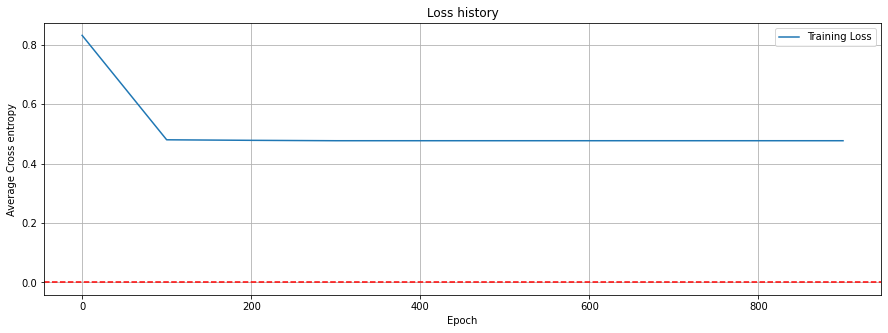

In [14]:
myqcnn.train(.5, 1000, np.arange(19), circuit=True, plot=True)

[ True False False False False False False False False False  True False
 False False False False False False False False  True False False False
 False False False False False False  True False False False False False
 False False False False  True False False False False False False False
 False False  True False False False False False False False False False
  True False False False False False False False False False  True False
 False False False False False False False False  True False False False
 False False False False False False  True False False False False False
 False False False False] [ True  True  True  True  True  True  True  True  True  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False 

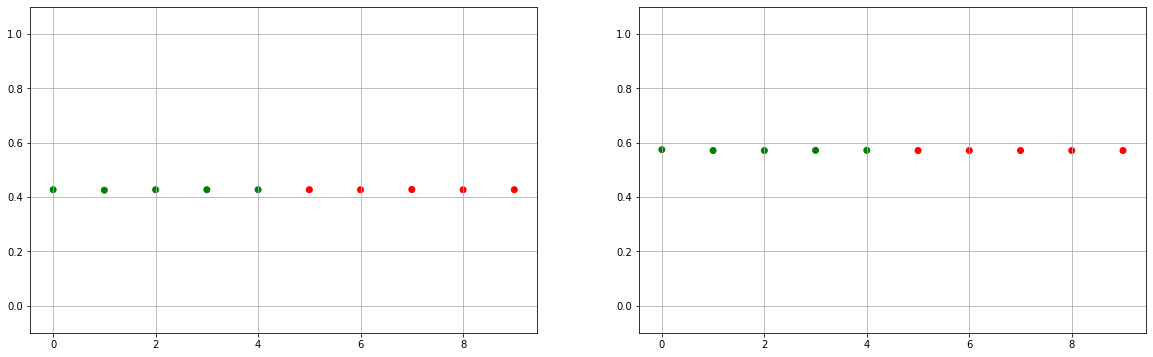

[[0.5735359  0.42646766]
 [0.4261479  0.5738557 ]]
[0 1]
[[0.5954314  0.40457243]
 [0.31174463 0.6882589 ]]
[0 1]
[[0.60436    0.39564323]
 [0.19777979 0.8022231 ]]
[0 1]
[[0.50983334 0.4901704 ]
 [0.08864447 0.91135913]]
[0 1]
[[0.37112734 0.6288763 ]
 [0.02396537 0.976038  ]]
[0 1]
[[0.25983745 0.7401659 ]
 [0.00433051 0.9956729 ]]
[1 1]
[[0.19524436 0.804759  ]
 [0.00125488 0.99874866]]
[1 1]
[[0.15619549 0.84380805]
 [0.00285658 0.997147  ]]
[1 1]
[[0.131357   0.86864734]
 [0.00568837 0.9943159 ]]
[1 1]
[[0.1142033  0.885801  ]
 [0.00874843 0.9912558 ]]
[1 1]


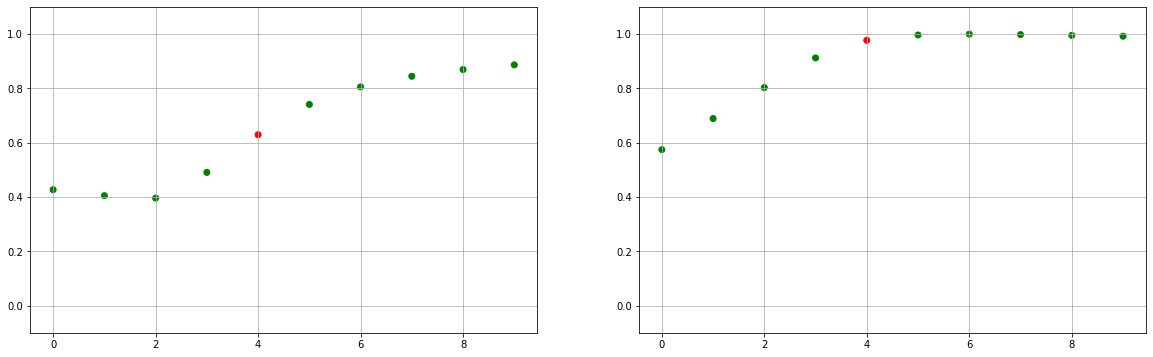

In [72]:
x1, y1 = myqcnn.show_results_annni()

In [12]:
@qml.qnode(myqcnn.device, interface="jax")
def qcnn_circuit_prob(params_vqe, params):
    _, active_wires = myqcnn.circuit(params_vqe, params)

    if len(active_wires) == 1:
        return qml.probs(wires=myqcnn.N - 1)
    else: return [qml.probs(wires=int(wire)) for wire in active_wires]

def compute_cross_entropy(X, Y, params):
    v_qcnn_prob = jax.vmap(lambda v: qcnn_circuit_prob(v, params))

    predictions = v_qcnn_prob(X)
    logprobs = jnp.log(predictions)
    
    print('Pred')
    print(predictions)
    return predictions
    print('Log')
    print(logprobs)
    print('Y')
    print(Y)
    Y = Y.flatten()
    logprobs = (jnp.reshape(logprobs.flatten(), (len(Y),2)))

    nll = jnp.take_along_axis(logprobs, jnp.expand_dims(Y, axis=1), axis=1)
    ce = - jnp.mean(nll)

    return ce

In [13]:
pre = compute_cross_entropy(x[:2], y[:2], myqcnn.params)

NameError: name 'x' is not defined

In [20]:
np.real( myqcnn.vqe.Hs.mat_Hs[0] )

DeviceArray([[ 0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,
              -1.,  0.,  0.,  0.],
             [ 0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,
               0., -1.,  0.,  0.],
             [ 0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0., -1.,  0.],
             [-1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0., -1.],
             [ 0.,  0., -1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.],
             [ 0.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0., -1.,  0.,  0.,
               0.,  0.,  0.,  0.],
             [-1.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0., -1.,  0.,
               0.,  0.,  0.,  0.],
             [ 0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
               0.,  0.,  0.,  0.],
             [ 0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
               0.,  0., -1.,  0.],
             [ 0., 

In [ ]:
y[:2]

In [ ]:
np.shape(pre)

In [ ]:
pre[:,:,1]

In [ ]:
pre

In [ ]:
(- np.log(1 - 0.03034729) - np.log(0.6870267) - np.log(1-0.04464145) - np.log(0.7675656) )/4

In [ ]:
myqcnn.params

In [ ]:
(- np.log(1 - 0.4561925) - np.log(0.4434047))/2